# 1- Data Acquisition

We are going to use a dataset that is already collected.

In [267]:
#we will do a basic NLP pipeline to classify movie genres based on the plot summary
#we will use the imdb dataset from kaggle

#we will use the following libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

#we will use the following datasets
twitter_train_data = pd.read_csv('twitter_training.csv')
twitter_val_data = pd.read_csv('twitter_validation.csv')

# Renommer les colonnes
twitter_train_data.columns = ['numero', 'nom', 'sentiment', 'review']
twitter_val_data.columns = ['numero', 'nom', 'sentiment', 'review']

df = pd.DataFrame(twitter_val_data)
#twitter_train_data.head()
print(type(twitter_train_data))
print(type(twitter_val_data))
print(twitter_val_data)


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
     numero                  nom   sentiment  \
0       352               Amazon     Neutral   
1      8312            Microsoft    Negative   
2      4371                CS-GO    Negative   
3      4433               Google     Neutral   
4      6273                 FIFA    Negative   
..      ...                  ...         ...   
994    4891  GrandTheftAuto(GTA)  Irrelevant   
995    4359                CS-GO  Irrelevant   
996    2652          Borderlands    Positive   
997    8069            Microsoft    Positive   
998    6960      johnson&johnson     Neutral   

                                                review  
0    BBC News - Amazon boss Jeff Bezos rejects clai...  
1    @Microsoft Why do I pay for WORD when it funct...  
2    CSGO matchmaking is so full of closet hacking,...  
3    Now the President is slapping Americans in the...  
4    Hi @EAHelp I’ve had Madeleine McCann in my cel...  
..   

In [268]:
import pandas as pd

# Suppose que twitter_train_data et twitter_val_data sont vos variables
# Vérifier le type de chaque variable
print(type(twitter_train_data))
print(type(twitter_val_data))

# Si l'une de ces variables n'est pas un DataFrame, convertissez-la en DataFrame
if not isinstance(twitter_train_data, pd.DataFrame):
    twitter_train_data = pd.DataFrame(twitter_train_data)

if not isinstance(twitter_val_data, pd.DataFrame):
    twitter_val_data = pd.DataFrame(twitter_val_data)

# Après avoir confirmé ou converti les types en DataFrame, concaténez-les
twitter_data = pd.concat([twitter_train_data, twitter_val_data], ignore_index=True)


twitter_data.head()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


,numero,nom,sentiment,review
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


# 2. Exploring the data

Whenever we start working with a new dataset, and before we move on to making design decisions and creating a model, we have to get to know our data. Let’s answer some questions regarding our dataset:

**What does a description of a movie looks like?**

In [269]:
#twitter_data[1]
#print(twitter_data.iloc[0])
twitter_data.review[4]

'im getting into borderlands and i can murder you all,'

In [270]:
#what a description looks like
# Compter le nombre d'occurrences où la colonne 'sentiment' a la valeur 'positive'
positive_count = twitter_data[twitter_data['sentiment'] == 'Positive'].count()
print(positive_count)


numero       21108
nom          21108
sentiment    21108
review       20931
dtype: int64


**How many genres has each movie?**

In [271]:
twitter_data.sentiment.value_counts()

sentiment
Negative      22808
Positive      21108
Neutral       18603
Irrelevant    13161
Name: count, dtype: int64

**How long are the descriptions? The longest description? Shortest descriptions?**

Mean description length:  108.128528012685
Min overview length:  1
Max overview length:  957


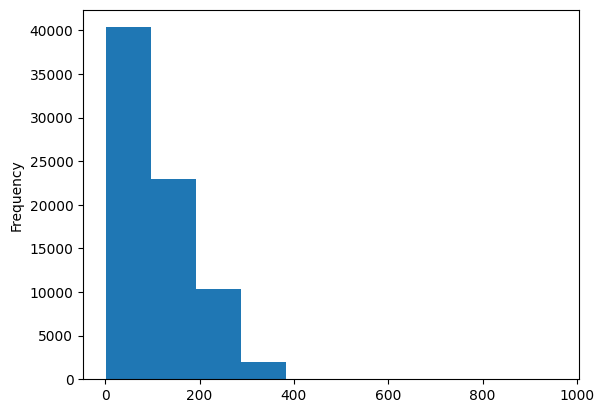

In [272]:
# Calcul de la longueur des descriptions après s'assurer que toutes les entrées sont des chaînes de caractères
twitter_data['description_length'] = twitter_data['review'].astype(str).apply(len)
print("Mean description length: ", twitter_data['description_length'].mean())
print("Min overview length: ", twitter_data['description_length'].min())
print("Max overview length: ", twitter_data['description_length'].max())

# Importer matplotlib pour la visualisation
import matplotlib.pyplot as plt

# Générer l'histogramme de la longueur des descriptions
twitter_data['description_length'].plot.hist()
plt.show()


# 3. Cleaning and Preprocessing

Now that we have a better understanding of the data in our hands, we can move on to cleaning the data. The goal of this stage is to remove irrelevant parts of our data before we use it to create our model. The definition of “irrelevant parts” varies between problems and datasets and, in real-world problems can be experimented to find the best way.

**First of all we need to decide which genre to use to carachterize each film**

In [273]:
# Utiliser uniquement le premier sentiment pour chaque tweet, si jamais il y a plusieurs sentiments séparés par des virgules
twitter_data['sentiment'] = twitter_data['sentiment'].apply(lambda x: x.split(',')[0])
twitter_data.head()


,numero,nom,sentiment,review,description_length
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,51
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,50
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,51
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,53


**How many films are out there for each genre?**

In [274]:
#how many movies are there for each genre
twitter_data.sentiment.value_counts()

sentiment
Negative      22808
Positive      21108
Neutral       18603
Irrelevant    13161
Name: count, dtype: int64

**We need to create our target variable (what are we going to classify)**

In [275]:
# Créer une variable cible qui est 1 si le sentiment est 'Positive' et 0 si c'est 'Negative'
twitter_data['target'] = twitter_data['sentiment'].apply(lambda x: 1 if x.lower() == 'positive' else 0 if x.lower() == 'negative' else None)

twitter_data.head()


,numero,nom,sentiment,review,description_length,target
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,51,1.0
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,50,1.0
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,51,1.0
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57,1.0
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,53,1.0


In [276]:
import nltk
from nltk.corpus import stopwords

# Télécharger les stopwords d'NLTK
nltk.download('stopwords')

# Définir la liste des stopwords en anglais
stop = stopwords.words('english')

# S'assurer que toutes les données de la colonne 'review' sont des chaînes de caractères
twitter_data['review'] = twitter_data['review'].astype(str)

# Supprimer les stopwords des reviews
twitter_data['review'] = twitter_data['review'].apply(lambda x: " ".join(word for word in x.split() if word not in stop))

# Afficher la première review après suppression des stopwords
print(twitter_data['review'][0])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rayan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


I coming borders I kill all,


**Just a word cloud to see what are the most common words in the action movies description**

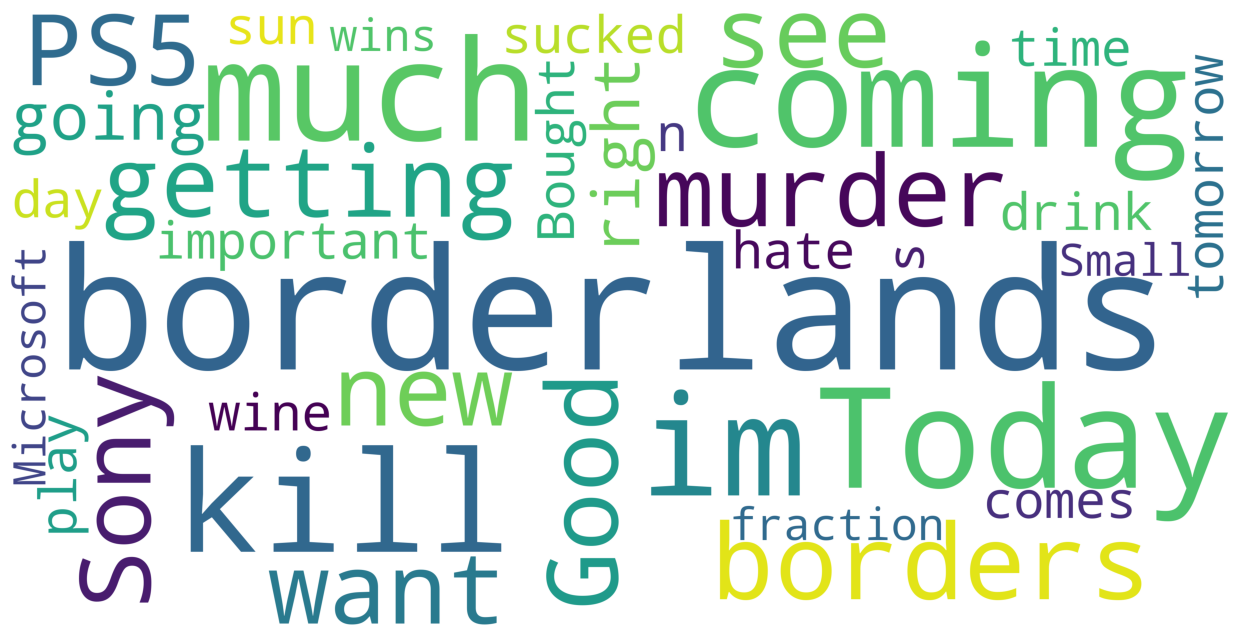

In [277]:
#we will create a word cloud to see the most common words in the descriptions if the movie is action
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
action = twitter_data[twitter_data['target'] == True]
action_text = action['review'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**We want to remove ponctuation, otherwise it will put noisy data into the classifier**

In [278]:
import string

exclude = set(string.punctuation)
def remove_punctuation(row):
    row.review = ''.join(ch for ch in row.review if ch not in exclude)
    return row
twitter_data = twitter_data.apply(remove_punctuation, axis = 1)

In [279]:
print(twitter_data['review'][0])

I coming borders I kill all


Mean description length:  79.69857293868922
Min overview length:  0
Max overview length:  854


<Axes: ylabel='Frequency'>

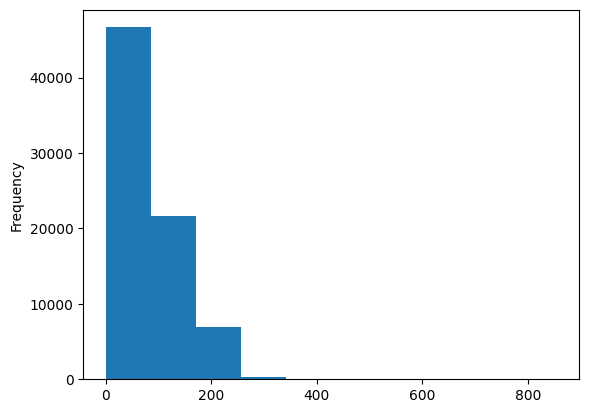

In [280]:
# how long are the descriptions

twitter_data['description_length'] = twitter_data.review.apply(len)
print("Mean description length: ", twitter_data['description_length'].mean())
print("Min overview length: ", twitter_data['description_length'].min())
print("Max overview length: ", twitter_data['description_length'].max())
twitter_data.description_length.plot.hist()

In [281]:
#we will put all the words in lower case
twitter_data['review'] = twitter_data['review'].apply(lambda x: x.lower())
twitter_data.review[1]

'im getting borderlands kill all'

**We can lemmatize our text**

Lemmatisation (or lemmatization) in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.

Lematisation looks at the context that sourrond the word before reducing it to its lemma. For instance, the word "meeting" can be either the base form of a noun or a form of a verb ("to meet") depending on the context; e.g., "in our last meeting" (noun) or "We are meeting again tomorrow" (verb). This process is similar to stemming, the difference is stemming reduces a word without looking to its context while lemmatisation attempts to select the correct lemma depending on the context.

In the "meeting" word example if we run stemming we get: meet. If we run Lemmatization we can get meet if it is a verb or meeting if it is a noun.

In [282]:
import nltk
from nltk.stem import WordNetLemmatizer

# Télécharger les ressources nécessaires de NLTK
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialiser le lemmatizer
lemmatizer = WordNetLemmatizer()


# Appliquer la lemmatisation sur chaque mot des reviews et joindre les mots en une seule chaîne
twitter_data['review'] = twitter_data['review'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))


# Assurer que les reviews sont des chaînes de caractères
twitter_data.review = twitter_data.review.astype(str)

# Afficher la première review après lemmatisation
print(twitter_data['review'][0])


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rayan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rayan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


i coming border i kill all


In [283]:
# we will lemmatize the words
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
twitter_data['review'] = twitter_data['review'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
twitter_data.review[1]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rayan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rayan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


'im getting borderland kill all'

In [284]:
# we will also do a stemming of the words to see if it improves the model
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
twitter_data['review_stemming'] = twitter_data['review'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
twitter_data.review_stemming[322]

'unk guy optu appear accid review start get good after apolog ill back tomorrow more borderland onc again apolog idea exactli'

**We also need to remove the stopwords**

Stop words are the words in a stop list (or stoplist or negative dictionary) which are filtered out (i.e. stopped) before or after processing of natural language data (text) because they are insignificant.

Examples of stopwords: of, from, a, are, their, by...

In [285]:
#we will remove stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
twitter_data['review'] = twitter_data['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

twitter_data.review[322]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rayan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'unk guy optus appears accident review start getting good apology ill back tomorrow borderland apology idea exactly'

In [286]:
import pandas as pd


from nltk.corpus import stopwords
stop = stopwords.words('english')


twitter_data['review_stemming'] = twitter_data['review_stemming'].apply(
    lambda x: " ".join(word for word in x.split() if word not in stop)
)

# Display the processed text at the specific index 322
print(twitter_data.review_stemming[322])


unk guy optu appear accid review start get good apolog ill back tomorrow borderland onc apolog idea exactli


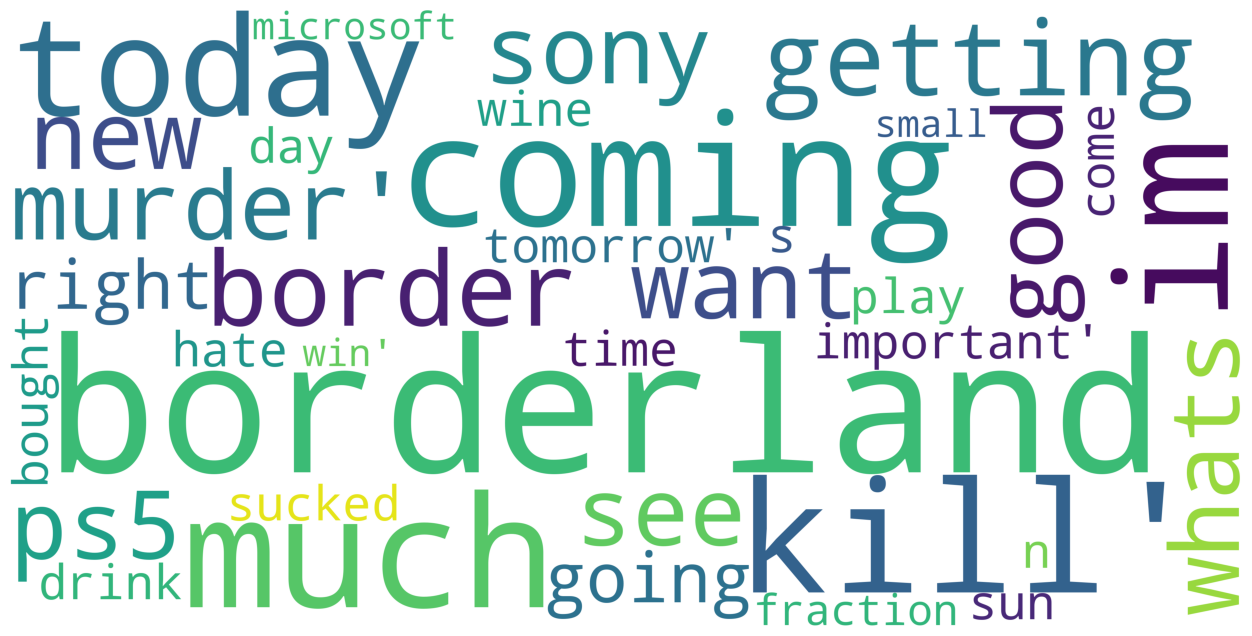

In [287]:
#we will create a word cloud to see the most common words in the descriptions if the movie is action
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
action = twitter_data[twitter_data['target'] == True]
action_text = action['review'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Other techniques are available to pre-process the text but for our example these are enough

If you are interested in exploring a little bit further you can check by yourself about Parts-of-speech tagging and Name Entity Recognition techniques for instance.

There are plenty of ready-to-use algorithms available at NLTK library and also at the Hugging Face website.

# 3. Vectorize the descriptions of movies in the dataset

The vectorization will transform each word into an integer or float point. This process is called vectorization or feature extraction. <br>
We will use **scikit-learn** to help us vectorize or text, more specifically we will use two models implemented in scikit-lear the Bag-of-Words Model and the TF-IDF.

### Bag-of-Words

This is the simplest way to vectorize the text. The strategy is to build a vocabulary of each word present in the text and then build a matrix where each line presents a document (film description) and each column a word in the whole set of documents. The content of each cell is the frequency each word appears in the document.

### TF-IDF (Term Frequency - Inverse Document Frequency)

A finer way to vectorize a text. TF-IDF also counts the frequency of terms but it penalizes a term if it is very frequent in the whole dataset. The logic is if a word is so common it is not good to characterize a specific document (for instance, the word 'Film' to the IMDB Dataset). However, if a word is frequent to only one film or a small set of films such a frequent word will have a higher value to characterize such film (for instance, the word water for the new Avatar film).

The matrix generated by TF-IDF also has a column to each unique word in the dataset but the values of the cells are given by the TF-IDF calculation.

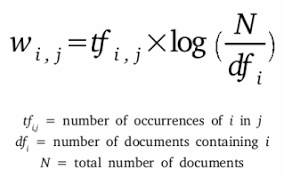

In [288]:
#we will create a bag of words model after lemmatization
cv = CountVectorizer()
X = cv.fit_transform(twitter_data['review'])
y = twitter_data['target']

In [289]:
#we will create a bag of words model after stemming
cv_stemming = CountVectorizer()
X_stemming = cv_stemming.fit_transform(twitter_data['review_stemming'])
y_stemming = twitter_data['target']

In [290]:
#we will also create a tfidf model after lemmatization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(twitter_data['review'])
y_tfidf = twitter_data['target']

In [291]:
# we will also create a tfidf model after stemming
tfidf_stemming = TfidfVectorizer()
X_tfidf_stemming = tfidf_stemming.fit_transform(twitter_data['review_stemming'])
y_tfidf_stemming = twitter_data['target']

# 4. Train Test Split

Because you know why

In [302]:
# Defining variables for lemmatization and stemming models using Bag of Words
X_lemmatization = X  # Already defined as X above
y_lemmatization = y  # Already defined as y above

X_stemming = X_stemming  # Already fit_transformed above
y_stemming = y  # Same target variable

# Defining variables for TF-IDF models after lemmatization and stemming
X_tfidf_lemmatization = X_tfidf  # Already fit_transformed above
y_tfidf_lemmatization = y  # Same target variable

X_tfidf_stemming = X_tfidf_stemming  # Already fit_transformed above
y_tfidf_stemming = y  # Same target variable

In [304]:
#we will split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101) #lemmatization
X_train_stemming, X_test_stemming, y_train_stemming, y_test_stemming = train_test_split(X_stemming, y_stemming, test_size=0.2, random_state=101) #stemming

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=101) #tfidf lemmatization
X_train_tfidf_stemming, X_test_tfidf_stemming, y_train_tfidf_stemming, y_test_tfidf_stemming = train_test_split(X_tfidf_stemming, y_tfidf_stemming, test_size=0.2, random_state=101) #tfidf stemming

ValueError: Found input variables with inconsistent numbers of samples: [43916, 75680]

# 5. Modeling

### Multinomial Naïve Bayes

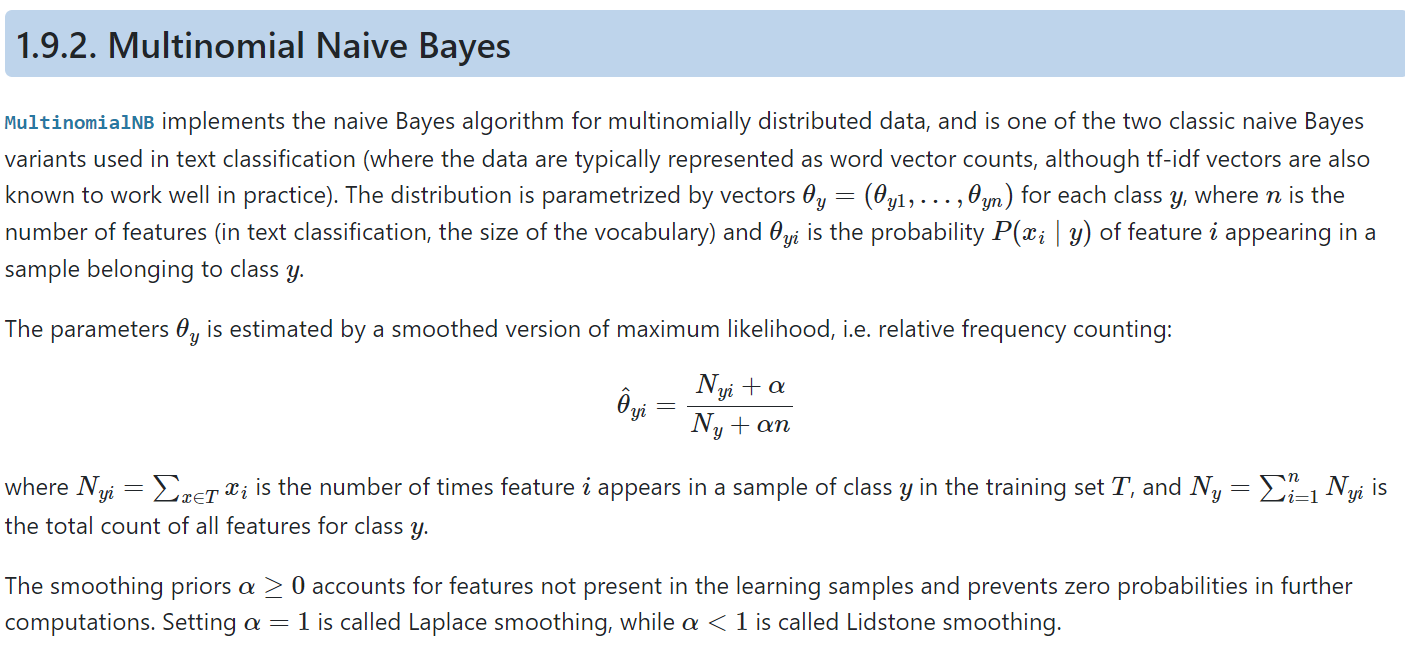

After computing the likelihood for each word in each class we compute the probability of a sample belonging to a class by using Bayes Rule as you implemented in Naïve Bayes from scratch.


In [294]:
# Supprimer les lignes où la cible 'y' est NaN
twitter_data = twitter_data.dropna(subset=['target'])

# Vous devrez recalculer les vecteurs X après avoir supprimé les lignes avec NaN
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer()
X_lemmatization = cv.fit_transform(twitter_data['review'])

cv_stemming = CountVectorizer()
X_stemming = cv_stemming.fit_transform(twitter_data['review_stemming'])

tfidf = TfidfVectorizer()
X_tfidf_lemmatization = tfidf.fit_transform(twitter_data['review'])

tfidf_stemming = TfidfVectorizer()
X_tfidf_stemming = tfidf_stemming.fit_transform(twitter_data['review_stemming'])

y_lemmatization = y_stemming = y_tfidf_lemmatization = y_tfidf_stemming = twitter_data['target']
#################################""
# Imputation des valeurs manquantes dans 'y'
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')  # Vous pouvez choisir une autre stratégie comme 'mean' ou 'median'

y_imputed = imputer.fit_transform(twitter_data[['target']]).ravel()  # Utiliser ravel pour convertir en 1D array

# Utiliser y_imputed pour les modèles
y_lemmatization = y_stemming = y_tfidf_lemmatization = y_tfidf_stemming = y_imputed



# 6. Evaluation

### Multinomial Naïve Bayes

In [296]:
from sklearn.metrics import classification_report, confusion_matrix

# Évaluation du modèle Naive Bayes avec lemmatisation et Bag of Words
print("Classification Report for Lemmatization with Bag of Words:")
print(classification_report(y_lemmatization, preds_lemmatization))

print("Confusion Matrix for Lemmatization with Bag of Words:")
print(confusion_matrix(y_lemmatization, preds_lemmatization))


Classification Report for Lemmatization with Bag of Words:
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90     22808
         1.0       0.90      0.89      0.89     21108

    accuracy                           0.90     43916
   macro avg       0.90      0.90      0.90     43916
weighted avg       0.90      0.90      0.90     43916

Confusion Matrix for Lemmatization with Bag of Words:
[[20733  2075]
 [ 2332 18776]]


In [297]:
from sklearn.metrics import classification_report, confusion_matrix

# Évaluation du modèle Naive Bayes avec stemming et Bag of Words
print("Classification Report for Stemming with Bag of Words:")
print(classification_report(y_stemming, preds_stemming))

print("Confusion Matrix for Stemming with Bag of Words:")
print(confusion_matrix(y_stemming, preds_stemming))


Classification Report for Stemming with Bag of Words:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89     22808
         1.0       0.89      0.88      0.88     21108

    accuracy                           0.89     43916
   macro avg       0.89      0.89      0.89     43916
weighted avg       0.89      0.89      0.89     43916

Confusion Matrix for Stemming with Bag of Words:
[[20577  2231]
 [ 2618 18490]]


In [298]:
from sklearn.metrics import classification_report, confusion_matrix

# Évaluation du modèle Naive Bayes avec lemmatisation et TF-IDF
print("Classification Report for Lemmatization with TF-IDF:")
print(classification_report(y_tfidf_lemmatization, preds_tfidf))

print("Confusion Matrix for Lemmatization with TF-IDF:")
print(confusion_matrix(y_tfidf_lemmatization, preds_tfidf))


Classification Report for Lemmatization with TF-IDF:
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92     22808
         1.0       0.93      0.87      0.90     21108

    accuracy                           0.91     43916
   macro avg       0.91      0.91      0.91     43916
weighted avg       0.91      0.91      0.91     43916

Confusion Matrix for Lemmatization with TF-IDF:
[[21472  1336]
 [ 2642 18466]]


In [299]:
from sklearn.metrics import classification_report, confusion_matrix

# Évaluation du modèle Naive Bayes avec stemming et TF-IDF
print("Classification Report for Stemming with TF-IDF:")
print(classification_report(y_tfidf_stemming, preds_tfidf_stemming))

print("Confusion Matrix for Stemming with TF-IDF:")
print(confusion_matrix(y_tfidf_stemming, preds_tfidf_stemming))


Classification Report for Stemming with TF-IDF:
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90     22808
         1.0       0.92      0.86      0.89     21108

    accuracy                           0.90     43916
   macro avg       0.90      0.90      0.90     43916
weighted avg       0.90      0.90      0.90     43916

Confusion Matrix for Stemming with TF-IDF:
[[21311  1497]
 [ 2987 18121]]


# 5. Multinomial Naïve Bayes from scratch

In [300]:
import numpy as np

class MultinomialNaiveBayes:
    def __init__(self):
        self.num_classes = None
        self.vocab_size = None
        self.class_prior = None
        self.word_conditional_prob = None

    def fit(self, X, y):
        num_samples, self.vocab_size = X.shape
        self.num_classes = np.max(y) + 1

        # Calculate class prior
        self.class_prior = np.zeros(self.num_classes)
        for c in range(self.num_classes):
            self.class_prior[c] = np.sum(y == c) / num_samples

        # Calculate word conditional probabilities
        self.word_conditional_prob = np.zeros((self.num_classes, self.vocab_size))
        for c in range(self.num_classes):
            X_c = X[y == c] # all samples that belong to class c
            total_word_count = np.sum(X_c) # total number of words in class c
            self.word_conditional_prob[c] = (np.sum(X_c, axis=0) + 1) / (total_word_count + self.vocab_size) # compute the conditional probability for each word in the vocabulary appearing in class c

    def predict(self, X):
        num_samples = X.shape[0]
        y_pred = np.zeros(num_samples)

        for i in range(num_samples):
            scores = np.zeros(self.num_classes)
            for c in range(self.num_classes):
                log_prob = np.log(self.class_prior[c]) * np.sum(np.log(self.word_conditional_prob[c] * X[i].T)) #compute the probability using bayes theorem and log to avoid underflow
                scores[c] = log_prob #store the probability for each class
                
            y_pred[i] = np.argmax(scores) #select the class with the highest probability

        return y_pred

In [301]:
model = MultinomialNaiveBayes()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

TypeError: expected a sequence of integers or a single integer, got '2.0'

In [ ]:
#we will evaluate the model with lemmatization and bag of words
print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.13      0.03      0.05      4959
           1       0.45      0.79      0.58      5041

    accuracy                           0.41     10000
   macro avg       0.29      0.41      0.31     10000
weighted avg       0.29      0.41      0.32     10000

[[ 153 4806]
 [1049 3992]]


# 5. Modeling

### Complement Naïve Bayes

In [ ]:
#we will implement Complement Naive Bayes with lemmatization and bag of words
from sklearn.naive_bayes import ComplementNB
cnb = ComplementNB()
cnb.fit(X_train, y_train)
preds_cnb = cnb.predict(X_test)

#we will implement Complement Naive Bayes with stemming and bag of words
cnb_stemming = ComplementNB()
cnb_stemming.fit(X_train_stemming, y_train_stemming)
preds_cnb_stemming = cnb_stemming.predict(X_test_stemming)

#we will implement Complement Naive Bayes with lemmatization and tfidf
cnb_tfidf_stemming = ComplementNB()
cnb_tfidf_stemming.fit(X_train_tfidf_stemming, y_train_tfidf_stemming)
preds_cnb_tfidf_stemming = cnb_tfidf_stemming.predict(X_test_tfidf_stemming)

#we will implement Complement Naive Bayes with stemming and tfidf
cnb_tfidf = ComplementNB()
cnb_tfidf.fit(X_train_tfidf, y_train_tfidf)
preds_cnb_tfidf = cnb_tfidf.predict(X_test_tfidf)

# 6. Evaluation

### Complement Naïve Bayes

In [ ]:
#we will evaluate the model with laemmatization and Bag of words
print(classification_report(y_test, preds_cnb))
print(confusion_matrix(y_test, preds_cnb))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      4959
           1       0.88      0.83      0.85      5041

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

[[4374  585]
 [ 845 4196]]


In [ ]:
#we will evaluate the model with stemming and Bag of words
print(classification_report(y_test_stemming, preds_cnb_stemming))
print(confusion_matrix(y_test_stemming, preds_cnb_stemming))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      4959
           1       0.88      0.83      0.85      5041

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

[[4374  585]
 [ 882 4159]]


In [ ]:
#we will evaluate the model with lemmatization and tfidf
print(classification_report(y_test_tfidf, preds_cnb_tfidf))
print(confusion_matrix(y_test_tfidf, preds_cnb_tfidf))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4959
           1       0.88      0.84      0.86      5041

    accuracy                           0.86     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.87      0.86      0.86     10000

[[4402  557]
 [ 793 4248]]


In [ ]:
#we will evaluate the model with stemming and tfidf
print(classification_report(y_test_tfidf_stemming, preds_cnb_tfidf_stemming))
print(confusion_matrix(y_test_tfidf_stemming, preds_cnb_tfidf_stemming))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      4959
           1       0.88      0.84      0.86      5041

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

[[4374  585]
 [ 805 4236]]
